In [1]:
import warnings
# warnings.filterwarnings('ignore')


In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib 
import os
import pickle
import plotly.graph_objects as go
import climetlab as cml

from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM2D, LSTM, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.utils import shuffle

2024-05-10 16:50:39.598794: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 16:50:40.530706: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [50]:
# INCA, 6 Jahre, Vienna, alle Parameter, hourly, timeseries
# timeseries (wieso sind da zwei Einträge da?)
# andere Städte geplant
def fetch_data(start_date = '2018-01-01T00', end_date='2024-01-01T00', lat_lon = '48.333056%2C16.631944'):
    url_template = ("https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?"
                    "parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&"
                    "parameters=RH2M&parameters=UU&parameters=VV&"
                    "start={start_date}%3A00&end={end_date}%3A00&lat_lon={lat_lon}&"
                    "output_format=geojson&filename=INCA_timeseries_all_parameters_{start_year}_{end_year}_{lat_lon}")
    formatted_url = url_template.format(start_date=start_date, end_date=end_date, lat_lon=lat_lon,
                                        start_year=start_date[:4], end_year=end_date[:4])
    print(formatted_url)
    response = requests.get(formatted_url)
    if response.status_code == 200:
        data = response.json()
        print("Fetched data successfully")
    else:
        print("Failed to retrieve data", response.status_code)

    # Processing the data
    data_list = []
    for feature in data['features']:
        location = feature['geometry']['coordinates']
        for i, timestamp in enumerate(data['timestamps']):
            record = {
                'time': pd.to_datetime(timestamp),
                'longitude': location[0],
                'latitude': location[1],
                'RR': feature['properties']['parameters']['RR']['data'][i],
                'T2M': feature['properties']['parameters']['T2M']['data'][i],
                'RH2M': feature['properties']['parameters']['RH2M']['data'][i],
                'TD2M': feature['properties']['parameters']['TD2M']['data'][i],
                'GL': feature['properties']['parameters']['GL']['data'][i],
                'UU': feature['properties']['parameters']['UU']['data'][i],
                'VV': feature['properties']['parameters']['VV']['data'][i],
                'P0': feature['properties']['parameters']['P0']['data'][i]
            }
            data_list.append(record)

    original_df = pd.DataFrame(data_list)
    return original_df


In [51]:
def fetch_training_data(date_latlon_pairs):
    all_data = []
    for dates, lat_lon in date_latlon_pairs:
        start_date, end_date = dates
        df = fetch_data(start_date, end_date, lat_lon)
        all_data.append(df)
    
    return pd.concat(all_data, ignore_index=True)


In [52]:
def assign_bimonthly(month):
    if month in [1, 2]:  # Jan-Feb
        return 'Jan-Feb'
    elif month in [3, 4]:  # Mar-Apr
        return 'Mar-Apr'
    elif month in [5, 6]:  # May-Jun
        return 'May-Jun'
    elif month in [7, 8]:  # Jul-Aug
        return 'Jul-Aug'
    elif month in [9, 10]:  # Sep-Oct
        return 'Sep-Oct'
    elif month in [11, 12]:  # Nov-Dec
        return 'Nov-Dec'
    return 'Unknown'

def bimonthly_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    return lower_bound, upper_bound



In [53]:
def assign_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    return 'unknown'

In [54]:

def seasonal_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound



In [55]:
def monthly_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def is_outlier(row, lower_bound, upper_bound):
    temperature = row['T2M']
    if temperature < lower_bound or temperature > upper_bound:
        return True
    return False


def replace_outliers(row, index, df):
    if row['is_outlier']:
        # Check if it's the first row
        if index == 0:
            return row['T2M']  # Or handle differently if the first value is an outlier
        else:
            return df.iloc[index - 1]['T2M']
    else:
        return row['T2M']


In [180]:
# feature engineering, mehr research
# more testing maybe for the paper, this right now is okay?

# statistical rolling features of the last x hours
def calculate_rolling_features(df, window_size, feature_name):
    if len(df) < window_size:
        window_size = len(df)  
    df[f'{feature_name}_rolling_mean'] = df['T2M'].rolling(window=window_size).mean()
    df[f'{feature_name}_rolling_max'] = df['T2M'].rolling(window=window_size).max()
    df[f'{feature_name}_rolling_min'] = df['T2M'].rolling(window=window_size).min()
    df[f'{feature_name}_rolling_std'] = df['T2M'].rolling(window=window_size).std()

# Exponential Weighted Moving Average (EWMA)
# which data are more important
def calculate_ewm_features(df, span_hours, feature_name):
    ewm_feature = f'{feature_name}_ewm_{span_hours}h'
    df[ewm_feature] = df[feature_name].ewm(span=span_hours, adjust=False).mean()

def handle_na(df):
    df.fillna(method='ffill', inplace=True)  
    df.fillna(method='bfill', inplace=True)  
    
def feature_engineering(df):
    df.dropna(inplace=True)  
    original_time_index = df['time'].copy()
    # Basic date-time features
    df['hour'] = df['time'].dt.hour
    df['day_of_year'] = df['time'].dt.dayofyear
    df['week_of_year'] = df['time'].dt.isocalendar().week
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year    
    df['longitude'] = df['longitude'].astype(float)
    df['latitude'] = df['latitude'].astype(float)
    df['season'] = df['time'].dt.month.apply(assign_season)


    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['time'].dt.dayofyear / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['time'].dt.dayofyear / 365)

    # Wind and interaction features
    df['wind_speed'] = np.sqrt(df['UU']**2 + df['VV']**2)
    df['wind_direction'] = np.arctan2(df['VV'], df['UU']) * 180 / np.pi
    df['temp_humidity_interaction'] = df['T2M'] * df['RH2M']
    df['wind_rain_interaction'] = df['wind_speed'] * df['RR']
    df['temp_rain_interaction'] = df['T2M'] * df['RR']
    df['wind_temp_interaction'] = df['wind_speed'] * df['T2M']

    # lags
    # Temperature lags
    for hrs in [1, 3, 6, 12, 24, 48]:
        df[f'T2M_lag_{hrs}hr'] = df['T2M'].shift(hrs)
    
    # Humidity lags
    for hrs in [1, 3]:
       df[f'RH2M_lag_{hrs}hr'] = df['RH2M'].shift(hrs)

    # differential
    df['T2M_diff'] = df['T2M'].diff()
    df['RH2M_diff'] = df['RH2M'].diff()
    #df['P0_diff'] = df['P0'].diff()

    df['temp_drop_event'] = df['T2M_diff'].apply(lambda x: 1 if x < -4 else 0)
    df['rain_event'] = df['RR'].apply(lambda x: 1 if x > 0 else 0)

    # EWM & rolling window
    calculate_ewm_features(df, 3, 'T2M')
    calculate_ewm_features(df, 6, 'T2M')
    calculate_ewm_features(df, 12, 'T2M')
    calculate_ewm_features(df, 24, 'T2M')
    #calculate_ewm_features(df, 48, 'T2M')
    #calculate_ewm_features(df, 72, 'T2M')
    #calculate_ewm_features(df, 24*7, 'T2M')
    calculate_ewm_features(df, 24*365, 'T2M')

    calculate_rolling_features(df,3, '3h')  # 24-hour window
    calculate_rolling_features(df, 6, '6h')  # 24-hour window
    calculate_rolling_features(df, 12, '12h')  # 24-hour window
    calculate_rolling_features(df, 24, '24h')  # 24-hour window
    #calculate_rolling_features(df, 48, '24h')  # 24-hour window
    #calculate_rolling_features(df, 72, '72h')  # 24-hour window
    #calculate_rolling_features(df, 24*7, '7d')  # 7-day window
    calculate_rolling_features(df, 24*365, '365d')  # 7-day window

    # Handle NaNs 
    handle_na(df)


    def correct_temperature(row):
        bimonthly_group = row['bimonthly']
        temperature = row['T2M']
        lower_bound, upper_bound = outlier_bounds[bimonthly_group]
        
        if temperature < lower_bound:
            return lower_bound  # Set to lower bound if below
        elif temperature > upper_bound:
            return upper_bound  # Set to upper bound if above
        return temperature  # Return original if within bounds
    
    df['bimonthly'] = df['time'].dt.month.apply(assign_bimonthly)
    
    # Calculate outlier bounds for each bimonthly group
    bimonthly_data = df.groupby('bimonthly')['T2M']
    outlier_bounds = bimonthly_data.apply(bimonthly_outliers)
    
    # Mark rows as outliers
    df['is_outlier'] = df.apply(lambda row: is_outlier(row, *outlier_bounds[row['bimonthly']]), axis=1)
    # This will display all rows where 'is_outlier' is True
    if not df.empty:
        if df['is_outlier'].any():
            print(df[df['is_outlier']])
        else:
            print("No outliers detected.")
    else:
        print("DataFrame is empty.")

    # Replace outliers
    df['T2M'] = df.apply(lambda row: replace_outliers(row, row.name, df), axis=1)
    
    # Optionally drop the 'is_outlier' column if no longer needed
    df.drop(columns=['is_outlier'], inplace=True)


    # only numeric types are used for modeling
    df = df.select_dtypes(include=[np.number])
    return df, original_time_index

In [57]:
def get_data_for_convlstm(start_date = '2018-01-01T00', end_date='2024-01-01T00'):
    df, time_index = feature_engineering(fetch_data(start_date, end_date).copy())
    return df, time_index

In [58]:
def create_sequences(input_data, param, sequence_length, feature_count, hours_to_predict, include_target=True):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - hours_to_predict + 1): 
        X.append(input_data.iloc[i:(i + sequence_length)].values)
        if include_target:
            y.append(input_data.iloc[i + sequence_length:i + sequence_length + hours_to_predict][param].values) 
    if include_target:
        # input X everything but T2M, output y just T2M
        return np.array(X), np.array(y)
    else:
        return np.array(X)  # Return only X if include_target is False

In [12]:
# Example usage:
date_latlon_pairs = [
    (('2018-01-01T00', '2024-01-01T00'), '48.333056%2C16.631944'),
    (('2018-01-01T00', '2024-01-01T00'), '48.115278%2C16.175833')
]

combined_df = fetch_training_data(date_latlon_pairs)
combined_df_copy = combined_df.copy()

https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2018-01-01T00%3A00&end=2024-01-01T00%3A00&lat_lon=48.333056%2C16.631944&output_format=geojson&filename=INCA_timeseries_all_parameters_2018_2024_48.333056%2C16.631944
Fetched data successfully
https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2018-01-01T00%3A00&end=2024-01-01T00%3A00&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_timeseries_all_parameters_2018_2024_48.115278%2C16.175833
Fetched data successfully


In [181]:
original_df, original_time_index = feature_engineering(combined_df.copy())

/tmp/ipykernel_33216/3674317405.py:20: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_33216/3674317405.py:21: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



                           time  longitude   latitude   RR    T2M   RH2M  \
10166 2019-02-28 14:00:00+00:00  16.638773  48.334339  0.0  18.96  26.18   
38195 2022-05-11 11:00:00+00:00  16.638773  48.334339  0.0  -9.99  34.26   
54000 2018-02-28 23:00:00+00:00  16.181034  48.112373  0.0 -15.29  83.80   
90780 2022-05-11 11:00:00+00:00  16.181034  48.112373  0.0  -9.99  40.98   

        TD2M      GL    UU    VV  ...  24h_rolling_mean  24h_rolling_max  \
10166  -0.85  316.31  8.80 -0.33  ...          7.957083            18.96   
38195   9.47  841.91  0.28  1.95  ...         16.651250            25.41   
54000 -17.40    0.00 -0.05 -0.04  ...        -11.821667            -8.90   
90780  10.89  815.88 -0.51  0.03  ...         16.477500            24.12   

       24h_rolling_min  24h_rolling_std  365d_rolling_mean  365d_rolling_max  \
10166            -0.21         6.494555          12.154715             34.98   
38195            -9.99         7.885237          11.212555             35.81  

In [182]:
df, time_index = original_df.copy(), original_time_index.copy()

In [183]:
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,12h_rolling_min,12h_rolling_std,24h_rolling_mean,24h_rolling_max,24h_rolling_min,24h_rolling_std,365d_rolling_mean,365d_rolling_max,365d_rolling_min,365d_rolling_std
0,16.638773,48.334339,0.000,1.68,94.58,0.91,0.0,-1.08,1.06,101026.92,...,0.40,1.448503,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,...,0.40,1.448503,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,...,0.40,1.448503,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,...,0.40,1.448503,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,...,0.40,1.448503,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,...,0.45,0.578554,1.450000,3.45,-0.91,1.274571,11.459591,33.79,-10.14,8.366507
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,...,0.65,0.499515,1.420417,3.45,-0.91,1.239458,11.459307,33.79,-10.14,8.366769
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,...,1.47,0.346623,1.353333,3.12,-0.91,1.166241,11.458772,33.79,-10.14,8.367234
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,...,1.47,0.799808,1.409583,4.47,-0.91,1.281970,11.458508,33.79,-10.14,8.367418


In [184]:
time_index

0        2018-01-01 00:00:00+00:00
1        2018-01-01 01:00:00+00:00
2        2018-01-01 02:00:00+00:00
3        2018-01-01 03:00:00+00:00
4        2018-01-01 04:00:00+00:00
                    ...           
105165   2023-12-31 20:00:00+00:00
105166   2023-12-31 21:00:00+00:00
105167   2023-12-31 22:00:00+00:00
105168   2023-12-31 23:00:00+00:00
105169   2024-01-01 00:00:00+00:00
Name: time, Length: 105110, dtype: datetime64[ns, UTC]

In [185]:
param = 'T2M'
sequence_length = 6
hours_to_predict = sequence_length

In [186]:
feature_count = df.shape[1]
print("Number of features:", feature_count)

Number of features: 64


In [187]:
scaler = MinMaxScaler()
# fit transform scaler
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,12h_rolling_min,12h_rolling_std,24h_rolling_mean,24h_rolling_max,24h_rolling_min,24h_rolling_std,365d_rolling_mean,365d_rolling_max,365d_rolling_min,365d_rolling_std
0,1.0,1.0,0.00000,0.336780,0.937915,0.462940,0.0,0.387728,0.561484,0.387203,...,0.360362,0.128723,0.382305,0.382353,0.410521,0.292638,0.786920,0.675545,0.261187,0.871494
1,1.0,1.0,0.00000,0.327015,0.956816,0.456202,0.0,0.343777,0.548272,0.377752,...,0.360362,0.128723,0.382305,0.382353,0.410521,0.292638,0.786920,0.675545,0.261187,0.871494
2,1.0,1.0,0.00000,0.312273,0.993356,0.448216,0.0,0.446475,0.522358,0.376098,...,0.360362,0.128723,0.382305,0.382353,0.410521,0.292638,0.786920,0.675545,0.261187,0.871494
3,1.0,1.0,0.00000,0.314379,1.000000,0.452957,0.0,0.461271,0.518293,0.374847,...,0.360362,0.128723,0.382305,0.382353,0.410521,0.292638,0.786920,0.675545,0.261187,0.871494
4,1.0,1.0,0.00000,0.313996,1.000000,0.452458,0.0,0.467798,0.529472,0.373324,...,0.360362,0.128723,0.382305,0.382353,0.410521,0.292638,0.786920,0.675545,0.261187,0.871494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105105,0.0,0.0,0.00000,0.347884,0.841810,0.445221,0.0,0.442994,0.517276,0.372732,...,0.361467,0.050081,0.334195,0.283878,0.377548,0.131346,0.569850,0.387409,0.526941,0.299839
105106,0.0,0.0,0.00000,0.352671,0.804238,0.437984,0.0,0.481723,0.532520,0.372102,...,0.365886,0.042937,0.333486,0.283878,0.377548,0.127411,0.569749,0.387409,0.526941,0.299959
105107,0.0,0.0,0.00000,0.339843,0.820962,0.427502,0.0,0.443429,0.516260,0.387165,...,0.384004,0.029115,0.331879,0.276688,0.377548,0.119204,0.569558,0.387409,0.526941,0.300173
105108,0.0,0.0,0.00000,0.390197,0.753837,0.466933,0.0,0.610096,0.591972,0.373615,...,0.384004,0.070082,0.333227,0.306100,0.377548,0.132176,0.569463,0.387409,0.526941,0.300258


In [188]:
validation_split=0.2
train_idx = int(len(df_scaled) * (1 - validation_split))

train_df = df_scaled.iloc[:train_idx]
test_df = df_scaled.iloc[train_idx:]

X_train, y_train = create_sequences(train_df, param, sequence_length, feature_count, hours_to_predict)
X_test, y_test = create_sequences(test_df, param, sequence_length, feature_count, hours_to_predict)

In [189]:
# Reshape for ConvLSTM
X_train = X_train.reshape((X_train.shape[0], sequence_length, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, X_test.shape[2]))

X_copy, y_copy = X_test.copy(), y_test.copy()

In [190]:
model = Sequential([
    LSTM(units=64, activation='relu', input_shape=(sequence_length, feature_count)),
    Dense(50, activation='relu'),
    Dense(hours_to_predict)
])

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')


/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [191]:
epochs=3
batch_size=32

checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True,
    monitor='val_loss', mode='min', save_best_only=True, verbose=1
)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
           validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/3
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061
Epoch 1: val_loss improved from inf to 0.00119, saving model to checkpoints/model_epoch_01_val_loss_0.00.weights.h5
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.0061 - val_loss: 0.0012
Epoch 2/3
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1690e-04
Epoch 2: val_loss improved from 0.00119 to 0.00079, saving model to checkpoints/model_epoch_02_val_loss_0.00.weights.h5
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 8.1681e-04 - val_loss: 7.9186e-04
Epoch 3/3
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5242e-04
Epoch 3: val_loss did not improve from 0.00079
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 7.5238e-04 - val_loss: 0.0010


In [192]:
formatted_date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_folder_name = f"model_folder{formatted_date_time}"
os.makedirs(model_folder_name, exist_ok=True)
model.save(os.path.join(model_folder_name, 'model.keras'))
joblib.dump(scaler, os.path.join(model_folder_name, 'scaler.pkl'))


['model_folder20240510_182520/scaler.pkl']

In [193]:
loaded_model = tf.keras.models.load_model(os.path.join(model_folder_name, 'model.keras'))
loaded_scaler = joblib.load(os.path.join(model_folder_name, 'scaler.pkl'))


In [194]:
#model_folder_name = "model_folder20240507_145010"
model = tf.keras.models.load_model(os.path.join(model_folder_name, 'model.keras'))
scaler = joblib.load(os.path.join(model_folder_name, 'scaler.pkl'))


In [195]:
def evaluate_temperature_forecast(actual, predicted):
    mse = np.mean((actual - predicted) ** 2)
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(mse)
    mbe = np.mean(predicted - actual)
    correlation = np.corrcoef(actual, predicted)[0, 1]
    explained_variance = explained_variance_score(actual, predicted)
    r2 = r2_score(actual, predicted)
    weights = np.where(actual >= 1.0, 2, 1)  
    b_mse = np.mean(weights * (actual - predicted) ** 2)
    b_mae = np.mean(weights * np.abs(actual - predicted))

    return {
        "MSE": mse,  # Mean Squared Error: Lower is better. Good < 0.5, Poor > 1.
        "MAE": mae,  # Mean Absolute Error: Lower is better. Good < 0.3, Poor > 0.6.
        "RMSE": rmse,  # Root Mean Square Error: Lower is better.
        "MBE": mbe,  # Mean Bias Error: Closer to 0 is better. Positive indicates overestimation; negative indicates underestimation.
        "Correlation": correlation,  # Closer to 1 is better. Indicates strength and direction of the linear relationship between predicted and actual values.
        "Explained Variance": explained_variance,  # Closer to 1 is better. 
        "R² Score": r2,  # Coefficient of Determination: Closer to 1 is better. Values > 0.7 are typically considered good, < 0.5 could be seen as poor.
        "B-MSE": b_mse,  # Balanced Mean Squared Error: Lower is better. Provides a weighted measure of MSE where significant errors have more influence.
        "B-MAE": b_mae  # Balanced Mean Absolute Error: Lower is better. Like B-MSE, it weights significant errors more heavily.
    }

657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


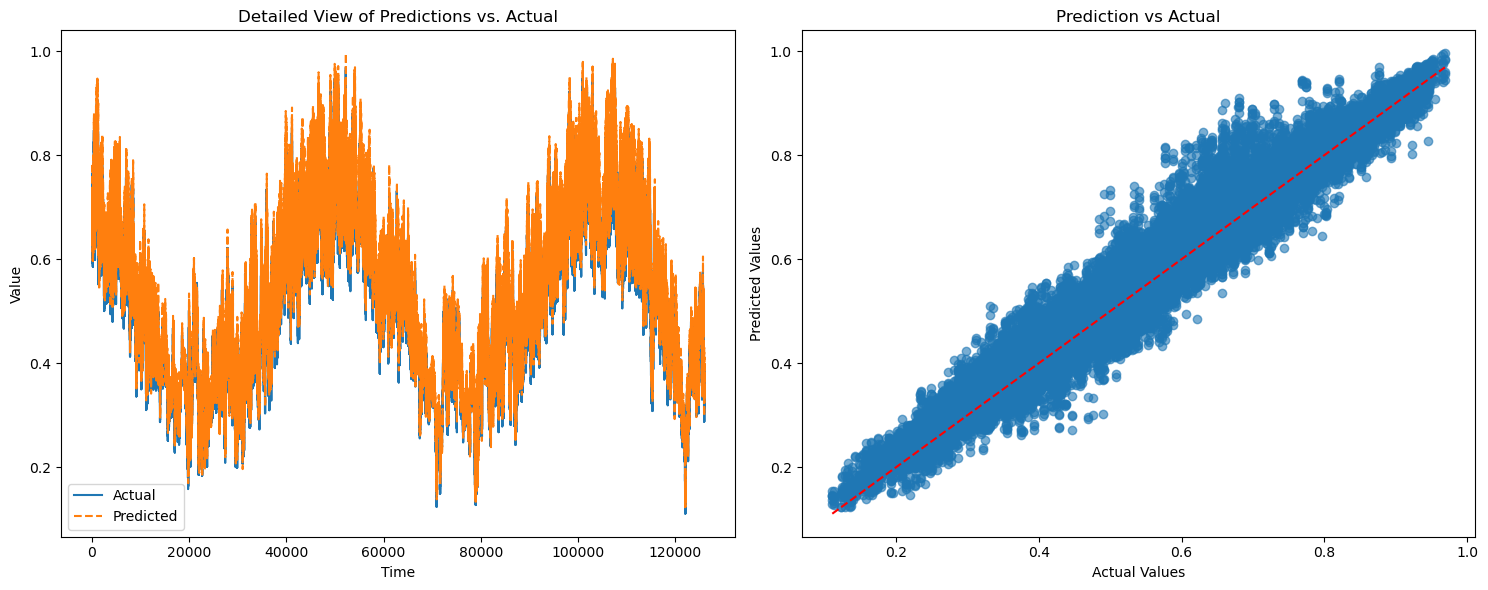

MSE: 0.0010349388534354005
MAE: 0.02522839789635805
RMSE: 0.03217046554582946
MBE: 0.019262608602615045
Correlation: 0.9869699299488475
Explained Variance: 0.9734706334007506
R² Score: 0.9586433886866259
B-MSE: 0.0010349388534354005
B-MAE: 0.02522839789635805


In [196]:
y_pred = model.predict(X_test).flatten()
y_test = y_test.flatten()

# make this a function
dummy_array = np.zeros((y_pred.shape[0], feature_count))
dummy_array[:, 3] = y_pred.squeeze() 
test_dummy_array = np.zeros((y_test.shape[0], feature_count))
test_dummy_array[:, 3] = y_test.squeeze()  
test_y = scaler.inverse_transform(test_dummy_array)[:, 3]
predictions_y = scaler.inverse_transform(dummy_array)[:, 3]

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual', linestyle='-')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Scatter plot of the actual vs predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') 

plt.tight_layout()
plt.show()

metrics = evaluate_temperature_forecast(y_test, y_pred)
for key, value in metrics.items():
    print(f"{key}: {value}")

https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-05-06T07%3A00&end=2024-05-09T08%3A00&lat_lon=48.333056%2C16.631944&output_format=geojson&filename=INCA_timeseries_all_parameters_2024_2024_48.333056%2C16.631944
Fetched data successfully
No outliers detected.
https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-05-09T08%3A00&end=2024-05-10T08%3A00&lat_lon=48.333056%2C16.631944&output_format=geojson&filename=INCA_timeseries_all_parameters_2024_2024_48.333056%2C16.631944


/tmp/ipykernel_33216/3674317405.py:20: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_33216/3674317405.py:21: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Fetched data successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
No outliers detected.


/tmp/ipykernel_33216/3674317405.py:20: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_33216/3674317405.py:21: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



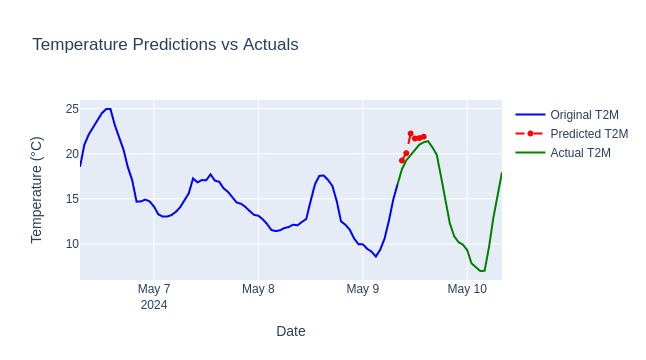

In [197]:
# prediction
#start_date = '2024-04-26T07'
#end_date = '2024-04-28T08'
start_date = '2024-05-06T07'
end_date = '2024-05-09T08'
df_pred = fetch_data(start_date, end_date)
data_for_prediction, time_index_pre_data = feature_engineering(df_pred) #get_data_for_convlstm('2024-04-23T00', '2024-05-01T08')
#print(df_pred)
#print(data_for_prediction)
##
start_date = '2024-05-09T08'
end_date = '2024-05-10T08'


df_act = fetch_data(start_date, end_date)
##
df_scaled = scaler.transform(data_for_prediction)
df_scaled = pd.DataFrame(df_scaled, columns=data_for_prediction.columns)
latest_sequence = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, feature_count)
future_temperatures = model.predict(latest_sequence)

# make this a function
dummy_output_array = np.zeros((hours_to_predict, scaler.n_features_in_))
dummy_output_array[:, 3] = future_temperatures.flatten()  # Ensure to flatten if necessary
predicted_temps = scaler.inverse_transform(dummy_output_array)[:, 3]

# Timestamp handling
data_for_prediction.index = time_index_pre_data
last_timestamp = data_for_prediction.index[-1]
prediction_frequency = 'H'
new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Fetch and set the actual data for comparison
data_actual_for_prediction, time_index_actual_data = feature_engineering(df_act) #get_data_for_convlstm('2024-05-01T08', '2024-05-02T08')
data_actual_for_prediction.index = time_index_actual_data

fig = go.Figure()
fig.add_trace(go.Scatter(x=data_for_prediction.index, y=data_for_prediction['T2M'], mode='lines', name='Original T2M', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Predicted T2M'], mode='lines+markers', name='Predicted T2M', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=data_actual_for_prediction.index, y=data_actual_for_prediction['T2M'], mode='lines', name='Actual T2M', line=dict(color='green')))

fig.update_layout(
    title='Temperature Predictions vs Actuals',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    hovermode="x unified"
)
fig.show()


In [152]:

def permutation_importance(model, X_val, y_val, feature_names, metric=mean_squared_error):
    # store the original model performance
    baseline_performance = metric(model.predict(X_val), y_val)
    importances = []

    # Iterate over each feature column
    for col in range(X_val.shape[-1]):
        save_col = X_val[..., col].copy()
        X_val[..., col] = shuffle(X_val[..., col])  # Shuffle the column
        m_performance = metric(model.predict(X_val), y_val)
        X_val[..., col] = save_col  # Restore original data
        importances.append(baseline_performance - m_performance)  # Decrease in performance

    # Pair feature names with their corresponding importances and sort by absolute importance
    importance_pairs = sorted(zip(feature_names, importances), key=lambda x: abs(x[1]), reverse=True)
    return importance_pairs

feature_names = df.columns.tolist()  
importances = permutation_importance(model, X_copy, y_copy, feature_names)

for feature, importance in importances:
    print(f"{feature}: {importance}")


657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
657/657 ━━━━━━━━

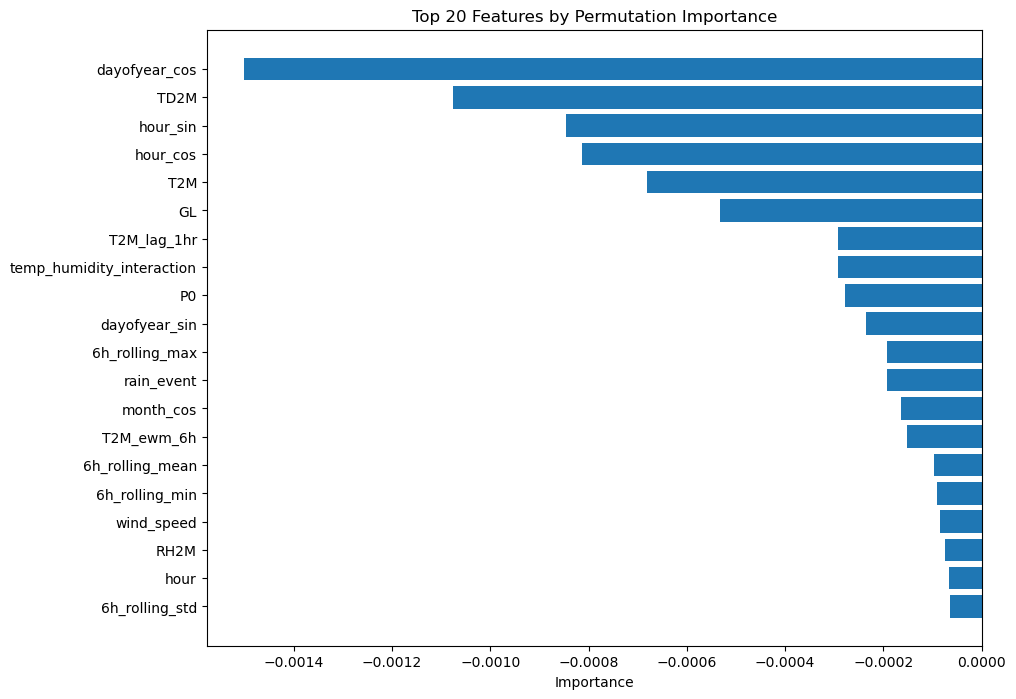

In [113]:
feature_names = [x[0] for x in importances]
importance_scores = [x[1] for x in importances]

plt.figure(figsize=(10, 8))
plt.barh(feature_names[:20], importance_scores[:20])  # Top 20 features
plt.xlabel('Importance')
plt.title('Top 20 Features by Permutation Importance')
plt.gca().invert_yaxis()  
plt.show()


In [ ]:
#first ver of emos function
def emos_adjustment(df_predictions, df_actuals):
    # Add day of year for seasonality
    df_predictions['doy'] = df_predictions['time'].dt.dayofyear
    df_actuals['doy'] = df_actuals['time'].dt.dayofyear

    # Add seasonal adjustment features
    seasonal_features = lambda doy: {
        'sin1_doy': np.sin(2 * np.pi * doy / 365),
        'cos1_doy': np.cos(2 * np.pi * doy / 365),
        'sin2_doy': np.sin(4 * np.pi * doy / 365),
        'cos2_doy': np.cos(4 * np.pi * doy / 365)
    }
    df_predictions = df_predictions.join(df_predictions['doy'].apply(lambda x: pd.Series(seasonal_features(x))))
    df_actuals = df_actuals.join(df_actuals['doy'].apply(lambda x: pd.Series(seasonal_features(x))))

    # Select the first hour prediction to compare with actuals (simplification)
    df_emos = pd.DataFrame({
        'predictions': df_predictions['Predicted T2M_1h'],
        'actuals': df_actuals['T2M'],
        'sin1_doy': df_predictions['sin1_doy'],
        'cos1_doy': df_predictions['cos1_doy'],
        'sin2_doy': df_predictions['sin2_doy'],
        'cos2_doy': df_predictions['cos2_doy']
    })

    # Fit models for mean and log variance
    X = sm.add_constant(df_emos[['predictions', 'sin1_doy', 'cos1_doy', 'sin2_doy', 'cos2_doy']])
    y_mu = df_emos['actuals']
    model_mu = sm.OLS(y_mu, X).fit()

    y_sigma = np.log((df_emos['predictions'] - df_emos['actuals'])**2)
    model_sigma = sm.OLS(y_sigma, X).fit()

    # Apply adjustments
    df_emos['adjusted_mu'] = model_mu.predict(X)
    df_emos['adjusted_sigma'] = np.exp(model_sigma.predict(X))

    return df_emos[['adjusted_mu', 'adjusted_sigma']]

In [ ]:
#to do
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def softplus_activation(x):
    """ Softplus activation function to ensure positive standard deviations. """
    return tf.math.log(1 + tf.math.exp(x))

def build_anet_model(input_dim, output_dim):
    """ Build the ANET model for post-processing ensemble predictions. """
    input_layer = Input(shape=(input_dim,))
    # Simple MLP with attention mechanism
    attention_weights = Dense(input_dim, activation='softmax', name='attention_weights')(input_layer)
    weighted_inputs = tf.multiply(input_layer, attention_weights)
    
    # Predicting ensemble corrections
    correction_means = Dense(output_dim, activation='linear', name='correction_means')(weighted_inputs)
    correction_stds = Dense(output_dim, activation=softplus_activation, name='correction_stds')(weighted_inputs)
    
    model = Model(inputs=input_layer, outputs=[correction_means, correction_stds])
    return model

def negative_log_likelihood(y_true, y_pred):
    """ Negative log-likelihood loss function for Gaussian predictions. """
    mean_pred, std_pred = y_pred
    mse = tf.square(y_true - mean_pred)
    variance = std_pred ** 2
    log_likelihood = 0.5 * tf.math.log(2 * np.pi * variance) + mse / (2 * variance)
    return tf.reduce_mean(log_likelihood)

# Parameters
input_dim = feature_count  # The number of features/ensemble members
output_dim = hours_to_predict  # Number of forecast hours

# Model
anet_model = build_anet_model(input_dim, output_dim)
optimizer = Adam(learning_rate=0.001)
anet_model.compile(optimizer=optimizer, loss=negative_log_likelihood)

# Example usage
#train_model, val_model could be parts of your dataset treated as ensemble predictions
anet_model.fit(model, 'T2M', validation_data=(val_model, val_labels), epochs=2)


In [ ]:
def emos_adjustment(df_predictions, df_actuals):
    # Add day of year for seasonality
    df_predictions['doy'] = df_predictions['time'].dt.dayofyear
    df_actuals['doy'] = df_actuals['time'].dt.dayofyear

    # Add seasonal adjustment features
    seasonal_features = lambda doy: {
        'sin1_doy': np.sin(2 * np.pi * doy / 365),
        'cos1_doy': np.cos(2 * np.pi * doy / 365),
        'sin2_doy': np.sin(4 * np.pi * doy / 365),
        'cos2_doy': np.cos(4 * np.pi * doy / 365)
    }
    df_predictions = df_predictions.join(df_predictions['doy'].apply(lambda x: pd.Series(seasonal_features(x))))
    df_actuals = df_actuals.join(df_actuals['doy'].apply(lambda x: pd.Series(seasonal_features(x))))

    # Select the first hour prediction to compare with actuals (simplification)
    df_emos = pd.DataFrame({
        'predictions': df_predictions['Predicted T2M_1h'],
        'actuals': df_actuals['T2M'],
        'sin1_doy': df_predictions['sin1_doy'],
        'cos1_doy': df_predictions['cos1_doy'],
        'sin2_doy': df_predictions['sin2_doy'],
        'cos2_doy': df_predictions['cos2_doy']
    })

    # Fit models for mean and log variance
    X = sm.add_constant(df_emos[['predictions', 'sin1_doy', 'cos1_doy', 'sin2_doy', 'cos2_doy']])
    y_mu = df_emos['actuals']
    model_mu = sm.OLS(y_mu, X).fit()

    y_sigma = np.log((df_emos['predictions'] - df_emos['actuals'])**2)
    model_sigma = sm.OLS(y_sigma, X).fit()

    # Apply adjustments
    df_emos['adjusted_mu'] = model_mu.predict(X)
    df_emos['adjusted_sigma'] = np.exp(model_sigma.predict(X))

    return df_emos[['adjusted_mu', 'adjusted_sigma']]

In [ ]:
def emos_adjustment(df_predictions, df_actuals):
    # Add day of year for seasonality
    df_predictions['doy'] = df_predictions['time'].dt.dayofyear
    df_actuals['doy'] = df_actuals['time'].dt.dayofyear

    # Add seasonal adjustment features
    seasonal_features = lambda doy: {
        'sin1_doy': np.sin(2 * np.pi * doy / 365),
        'cos1_doy': np.cos(2 * np.pi * doy / 365),
        'sin2_doy': np.sin(4 * np.pi * doy / 365),
        'cos2_doy': np.cos(4 * np.pi * doy / 365)
    }
    df_predictions = df_predictions.join(df_predictions['doy'].apply(lambda x: pd.Series(seasonal_features(x))))
    df_actuals = df_actuals.join(df_actuals['doy'].apply(lambda x: pd.Series(seasonal_features(x))))

    # Select the first hour prediction to compare with actuals (simplification)
    df_emos = pd.DataFrame({
        'predictions': df_predictions['Predicted T2M_1h'],
        'actuals': df_actuals['T2M'],
        'sin1_doy': df_predictions['sin1_doy'],
        'cos1_doy': df_predictions['cos1_doy'],
        'sin2_doy': df_predictions['sin2_doy'],
        'cos2_doy': df_predictions['cos2_doy']
    })

    # Fit models for mean and log variance
    X = sm.add_constant(df_emos[['predictions', 'sin1_doy', 'cos1_doy', 'sin2_doy', 'cos2_doy']])
    y_mu = df_emos['actuals']
    model_mu = sm.OLS(y_mu, X).fit()

    y_sigma = np.log((df_emos['predictions'] - df_emos['actuals'])**2)
    model_sigma = sm.OLS(y_sigma, X).fit()

    # Apply adjustments
    df_emos['adjusted_mu'] = model_mu.predict(X)
    df_emos['adjusted_sigma'] = np.exp(model_sigma.predict(X))

    return df_emos[['adjusted_mu', 'adjusted_sigma']]


# Fetch new data for making predictions
new_start_date = '2024-05-01T09'
new_end_date = '2024-05-02T08'
new_data, new_time_index = get_data_for_convlstm(new_start_date, new_end_date)

# Ensure 'time' column is correctly formatted and excluded from scaling
new_data['time'] = pd.to_datetime(new_time_index)
time_column = new_data['time']  # Save the time column for later use
data_for_scaling = new_data.drop('time', axis=1)  # Drop non-numerical columns

# Scale the data using the pre-trained scaler
new_data_scaled = scaler.transform(data_for_scaling)
new_data_scaled_df = pd.DataFrame(new_data_scaled, columns=data_for_scaling.columns)

# Add the 'time' column back to the scaled DataFrame
new_data_scaled_df['time'] = time_column

# Generate sequences for model prediction
sequence_length = 24  # Define sequence length used during model training
feature_count = new_data_scaled_df.shape[1] - 1  # excluding the time column
hours_to_predict = 6  # Define how many hours ahead the model should predict
new_X = create_sequences(new_data_scaled_df.drop('time', axis=1), 'T2M', sequence_length, feature_count, hours_to_predict, include_target=False)
new_X = new_X.reshape((new_X.shape[0], sequence_length, 1, 1, feature_count))

# Make predictions
predictions = model.predict(new_X)

# Create new timestamps for predictions
prediction_time_index = pd.date_range(start=new_time_index[-1], periods=hours_to_predict, freq='H')

# Create DataFrame for predictions
predictions_df = pd.DataFrame(predictions, index=prediction_time_index, columns=new_data_scaled_df.columns[:-1])

# Add 'time' column to the DataFrame
predictions_df['time'] = prediction_time_index

# Reorder columns to have 'time' as the first column
predictions_df = predictions_df[['time'] + list(predictions_df.columns[:-1])]

# Display the DataFrame
predictions_df
#predictions_df = pd.DataFrame(predictions, index=new_time_index[-len(predictions):], columns=new_data_scaled_df.columns.intersection(predictions))
#predictions_df['time'] = pd.to_datetime(new_time_index[-len(predictions):])  # Ensure time column is set correctly

# Re-run EMOS adjustment with clean data
print(predictions_df, new_data)
adjusted_predictions = emos_adjustment(predictions_df, new_data)




In [ ]:
start_date_predict = '2024-04-25T00'
end_date_predict = '2024-05-01T08'
data_for_prediction, time_index_pre_data = get_data_for_convlstm(start_date_predict, end_date_predict)

# Transform the data for prediction
df_scaled = scaler.transform(data_for_prediction)
df_scaled = pd.DataFrame(df_scaled, columns=data_for_prediction.columns)

# Prepare sequences for prediction
sequence_length = 24  # Define sequence length as used in your model training
feature_count = df_scaled.shape[1]
latest_sequence = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, 1, 1, feature_count)

# Predict future temperatures
future_temperatures = model.predict(latest_sequence)

# Assuming 'future_temperatures' returns predictions for multiple hours ahead, 
# let's adjust the `dummy_output_array` to match the number of predictions.

# Reverse scaling to get actual temperature values
num_predictions = len(future_temperatures.flatten())  # Number of prediction points
dummy_output_array = np.zeros((num_predictions, feature_count))  # Adjusted for multiple predictions
dummy_output_array[:, 3] = future_temperatures.flatten()  # Assuming 'T2M' is at index 3
predicted_temps = scaler.inverse_transform(dummy_output_array)[:, 3]

# Check if time_index_pre_data is a pandas Series or DataFrame column
if isinstance(time_index_pre_data, pd.Series):
    last_timestamp = pd.to_datetime(time_index_pre_data.iloc[-1])
elif isinstance(time_index_pre_data, pd.DataFrame):
    last_timestamp = pd.to_datetime(time_index_pre_data.iloc[-1, 0])  # Assuming time is in the first column
else:
    # Fallback if it's a list or numpy array
    last_timestamp = pd.to_datetime(time_index_pre_data[-1])

# Continue with the timestamp handling
prediction_frequency = 'H'
num_predictions = len(future_temperatures.flatten())
new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=num_predictions, freq=prediction_frequency)
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Fetch actual data for the same prediction period for comparison and EMOS adjustments
start_date_actual = '2024-05-01T08'
end_date_actual = '2024-05-02T08'
data_actual_for_prediction, time_index_actual_data = get_data_for_convlstm(start_date_actual, end_date_actual)

# Create DataFrame for actuals
actuals_df = pd.DataFrame({
    'time': time_index_actual_data,
    'temperature': data_actual_for_prediction['T2M']  # Assuming 'T2M' is the temperature column
})

# Apply EMOS Adjustments
adjusted_emos = emos_adjustment(predictions_df, actuals_df)
print(adjusted_emos.head())

In [ ]:
start_date = '2023-01-01T00'
end_date = '2023-12-31T00'
raw_data = fetch_data(start_date, end_date)

# Step 2: Process and Engineer Features
processed_data, time_index = feature_engineering(raw_data.copy())

# Step 3: Simulate Predictions (normally you'd use a trained model)
# For demonstration, let's assume predictions are slightly off from the actual T2M readings
predictions = processed_data.copy()
predictions['temperature_predictions'] = predictions['T2M'] + np.random.normal(0, 0.5, size=len(predictions))

# Creating DataFrame for predictions and actuals
df_predictions = pd.DataFrame({
    'time': time_index,
    'temperature_predictions': predictions['temperature_predictions']
})

df_actuals = pd.DataFrame({
    'time': time_index,
    'temperature': processed_data['T2M']
})

# Step 4: Apply EMOS Adjustments
adjusted_emos = emos_adjustment(df_predictions, df_actuals)
print(adjusted_emos.head())

In [ ]:
#train data
data, index_data = get_data_for_convlstm('2024-04-25T00', '2024-05-01T08')
test_scaler = copy.deepcopy(scaler)
# Transform the data for prediction
data_scaled = test_scaler.transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)
#latest_sequence = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, 1, 1, feature_count)

X, y = create_sequences(data_scaled, param, sequence_length, feature_count, hours_to_predict)


# Predict using the model
pred_data = model.predict(X.reshape((-1, sequence_length, 1, 1, feature_count)))
data['time'] = index_data  # Assuming index_data contains the datetime index
last_timestamp = data['time'].iloc[-1]

# Post-prediction transformation back
dummy_output_array = np.zeros((pred_data.shape[0], test_scaler.n_features_in_))
dummy_output_array[:, 3] = pred_data.flatten()  # Assume the third index is T2M
predicted_temps = test_scaler.inverse_transform(dummy_output_array)[:, 3]

# Create a DataFrame for predictions
prediction_frequency = 'H'
new_timestamps = pd.date_range(start=last_timestamp + timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])
predictions_df['day_of_year'] = new_timestamps.dayofyear

# Step 2: Fetch Actual Data for Comparison
data_actual_for_prediction, time_index_actual_data = get_data_for_convlstm('2024-05-01T08', '2024-05-01T16')
data_actual_for_prediction['time'] = time_index_actual_data
data_actual_for_prediction.set_index('time', inplace=True)

# Filter only necessary columns for actuals
data_actual_for_prediction = data_actual_for_prediction[['T2M', 'day_of_year']]

# Print outputs for verification
print(predictions_df.head())
print(data_actual_for_prediction.head())


In [ ]:
actual_temps = data_actual_for_prediction['T2M'].reindex(predictions_df.index, method='nearest')  # Ensure alignment
predicted_temps = predictions_df['Predicted T2M']
metrics = calculate_nowcasting_metrics(actual_temps.values, predicted_temps.values)
print(metrics)

In [ ]:
def seasonal_adjustment(doy):
    return {
        'sin1_doy': np.sin(2 * np.pi * doy / 365),
        'cos1_doy': np.cos(2 * np.pi * doy / 365),
        'sin2_doy': np.sin(4 * np.pi * doy / 365),
        'cos2_doy': np.cos(4 * np.pi * doy / 365)
    }


In [ ]:
# Assuming 'get_data_for_convlstm' is defined elsewhere and properly implemented
data_for_prediction, time_index_pre_data = get_data_for_convlstm('2024-04-20T00', '2024-04-28T08')

# Ensure scaler is fitted; if it's the first use, fit on some initial data or the current data
scaler = MinMaxScaler()
scaler.fit(data_for_prediction)  # Fit if not already done; else skip

# Transform the data for prediction
df_scaled = scaler.transform(data_for_prediction)
df_scaled = pd.DataFrame(df_scaled, columns=data_for_prediction.columns)
latest_sequence = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, 1, 1, feature_count)
future_temperatures = model.predict(latest_sequence)
dummy_output_array = np.zeros((hours_to_predict, scaler.n_features_in_))
dummy_output_array[:, 3] = future_temperatures.flatten()  # Ensure to flatten if necessary
predicted_temps = scaler.inverse_transform(dummy_output_array)[:, 3]

# Timestamp handling
data_for_prediction.index = time_index_pre_data
last_timestamp = data_for_prediction.index[-1]
prediction_frequency = 'H'
new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Fetch and set the actual data for comparison
data_actual_for_prediction, time_index_actual_data = get_data_for_convlstm('2024-04-28T08', '2024-04-29T00')
data_actual_for_prediction.index = time_index_actual_data


In [ ]:
# Assume 'df_predictions' holds the predictions and their corresponding times
# Assume 'df_actuals' holds the actual observed temperatures and their corresponding times
df_predictions['doy'] = df_predictions['time'].dt.dayofyear
df_actuals['doy'] = df_actuals['time'].dt.dayofyear

# Add seasonal features
df_predictions = df_predictions.join(df_predictions['doy'].apply(lambda x: pd.Series(seasonal_adjustment(x))))
df_actuals = df_actuals.join(df_actuals['doy'].apply(lambda x: pd.Series(seasonal_adjustment(x))))

# Prepare the DataFrame for fitting EMOS
df_emos = pd.DataFrame({
    'predictions': df_predictions['temperature_predictions'],
    'actuals': df_actuals['temperature'],
    'doy': df_predictions['doy'],
    **df_predictions[['sin1_doy', 'cos1_doy', 'sin2_doy', 'cos2_doy']]
})


In [ ]:
import statsmodels.api as sm

# Model for the mean μ(t)
X_mu = sm.add_constant(df_emos[['predictions', 'sin1_doy', 'cos1_doy', 'sin2_doy', 'cos2_doy']])
y_mu = df_emos['actuals']
model_mu = sm.OLS(y_mu, X_mu).fit()

# Model for log variance log(σ)
X_sigma = X_mu  # Using the same predictors for simplicity, though you might choose differently
y_sigma = np.log((df_emos['predictions'] - df_emos['actuals'])**2)  # Simple variance estimation
model_sigma = sm.OLS(y_sigma, X_sigma).fit()


In [ ]:
# Predict adjustments
df_emos['adjusted_mu'] = model_mu.predict(X_mu)
df_emos['adjusted_sigma'] = np.exp(model_sigma.predict(X_sigma))

# These adjusted predictions can now be used in your evaluation or deployment


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Assuming fetch_data and feature_engineering functions are available

def fetch_and_process_data():
    # Fetch data
    df_raw = fetch_data()  # You need to define or replace fetch_data with actual implementation
    df_processed, time_index = feature_engineering(df_raw.copy())  # Similarly, ensure feature_engineering is correctly implemented
    return df_processed, time_index

df, time_index = fetch_and_process_data()


In [ ]:
model_folder_name = "model_folder20240504_134242"
model = tf.keras.models.load_model(os.path.join(model_folder_name, 'model.keras'))
scaler = joblib.load(os.path.join(model_folder_name, 'scaler.pkl'))


In [ ]:
df_scaled = scaler.transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
hours_to_predict = 10

X_train, y_train = create_sequences(df_scaled, param, sequence_length, feature_count, hours_to_predict)

latest_sequence = X_train.reshape(1, sequence_length, 1, 1, feature_count)

future_temperatures = model.predict(latest_sequence)
dummy_output_array = np.zeros((df_scaled[0], scaler.n_features_in_))
dummy_output_array[:, 3] = future_temperatures.flatten()  # Ensure to flatten if necessary
predicted_temps = scaler.inverse_transform(dummy_output_array)


# Timestamp handling
#data_for_prediction.index = time_index_pre_data
#last_timestamp = data_for_prediction.index[-1]
#prediction_frequency = 'H'
#new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)
#predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Fetch and set the actual data for comparison
#data_actual_for_prediction, time_index_actual_data = get_data_for_convlstm('2024-04-28T08', '2024-04-29T00')
#data_actual_for_prediction.index = time_index_actual_data


In [ ]:
# Print the shape of X_train to understand its current structure
print("Shape of X_train:", X_train.shape)


In [ ]:

# Add 'day of the year' for EMOS adjustments

# Normalize the data

#df_numeric = df[numeric_cols]
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)


X = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, 1, 1, feature_count)
#future_temperatures = model.predict(latest_sequence)

# Make predictions
predictions = model.predict(X).flatten()
#dummy_output_array = np.zeros((hours_to_predict, scaler.n_features_in_))
#dummy_output_array[:, 3] = predictions.flatten() 
#predictions_rescaled = scaler.inverse_transform(predictions)  # Assume predictions need rescaling



In [ ]:
predictions

In [ ]:
# Reshape data for ConvLSTM (assuming this is required by your model)
#X = df_scaled.values.reshape((df_scaled.shape[0], 1, 1, df_scaled.shape[1]))  # Change as per your model's input requirement


X = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, 1, 1, feature_count)
#future_temperatures = model.predict(latest_sequence)

# Make predictions
predictions = model.predict(X)
predictions_rescaled = scaler.inverse_transform(predictions)  # Assume predictions need rescaling


In [ ]:
# Create a DataFrame to hold predictions and actual data for fitting EMOS
df_emos = pd.DataFrame({
    'doy': df['doy'],
    'predictions_y': predictions_rescaled.flatten(),  # Flatten if necessary
    'test_y': df['actual_temperature']  # Replace 'actual_temperature' with the column name from your dataset containing actual temperatures
})

# Adding a constant and doy features for regression
X = sm.add_constant(df_emos[['doy', 'predictions_y']])
y = df_emos['test_y']

# Fit the EMOS model for mean adjustment
model_mu = sm.OLS(y, X).fit()

# Calculate residuals as a proxy for sigma if not directly available
df_emos['log_sigma'] = np.log(np.abs(df_emos['predictions_y'] - df_emos['test_y']))

X_sigma = sm.add_constant(df_emos[['doy', 'log_sigma']])
model_sigma = sm.OLS(df_emos['log_sigma'], X_sigma).fit()

# Predict adjusted values
df_emos['adjusted_mu'] = model_mu.predict(X)
df_emos['adjusted_sigma'] = np.exp(model_sigma.predict(X_sigma))


In [ ]:
def seasonal_features(doy):
    return {
        'sin1': np.sin(2 * np.pi * doy / 365),
        'cos1': np.cos(2 * np.pi * doy / 365),
        'sin2': np.sin(4 * np.pi * doy / 365),
        'cos2': np.cos(4 * np.pi * doy / 365)
    }


In [ ]:
# Example of creating a DataFrame
data = {
    'date': pd.date_range(start='2020-01-01', periods=100, freq='D'),
    'predictions_y': np.random.normal(loc=20, scale=5, size=100),  # Simulated temperature predictions
    'test_y': np.random.normal(loc=20, scale=5, size=100)  # Simulated actual temperatures
}

df = pd.DataFrame(data)
df['doy'] = df['date'].dt.dayofyear
df

In [ ]:
import statsmodels.api as sm

# Adding a constant for the regression model
X = sm.add_constant(df[['doy', 'predictions_y']])

# Dependent variable from the DataFrame
y = df['test_y']

# Fit the model for the mean (μ)
model_mu = sm.OLS(y, X).fit()

# If calculating log sigma requires actual sigma values, ensure you have this data or an approximation
# Example of calculating a simple log sigma if not provided
df['log_sigma'] = np.log(np.abs(df['predictions_y'] - df['test_y']))

X_sigma = sm.add_constant(df[['doy', 'log_sigma']])
model_sigma = sm.OLS(df['log_sigma'], X_sigma).fit()

# Make predictions
df['adjusted_mu'] = model_mu.predict(X)
df['adjusted_sigma'] = np.exp(model_sigma.predict(X_sigma))  # Exponentiate to revert the log transformation
df

In [ ]:
import statsmodels.api as sm

# Assume df has columns 'doy', 'predictions_y', and 'test_y'
X = sm.add_constant(df[['doy', 'predictions_y']])  # Including doy for seasonal adjustments
y = df['test_y']

# Fit the model for μ
model_mu = sm.OLS(y, X).fit()

# Assuming you have calculated log standard deviations as `log_sigma`
X_sigma = sm.add_constant(df[['doy', 'log_sigma']])  # log_sigma could be calculated as np.log(predictions_y - test_y).abs()
model_sigma = sm.OLS(np.log(y - df['predictions_y']).abs(), X_sigma).fit()

# Predict adjustments
df['adjusted_mu'] = model_mu.predict(X)
df['adjusted_sigma'] = np.exp(model_sigma.predict(X_sigma))


In [ ]:
# Assuming 'mu_ens' and 'sigma_ens' are columns in your forecast DataFrame, containing ensemble mean and std dev

# Prepare your features with the seasonal functions added
seasonal_data = pd.DataFrame(list(forecast_df['doy'].apply(seasonal_features)))
X_mu = sm.add_constant(pd.concat([forecast_df[['doy']], seasonal_data, forecast_df['mu_ens']], axis=1))  # Include mu_ens from your model predictions
X_sigma = sm.add_constant(pd.concat([forecast_df[['doy']], seasonal_data, np.log(forecast_df['sigma_ens'])], axis=1))  # Log of ensemble std dev

# Response variables
y_mu = observed_df['temperature']  # Actual temperatures
y_sigma = np.log(observed_df['sigma'])  # Assuming you have observed standard deviations

# Fit the regression models
model_mu = sm.OLS(y_mu, X_mu).fit()
model_sigma = sm.OLS(y_sigma, X_sigma).fit()


In [ ]:
forecast_df['adjusted_mu'] = model_mu.predict(X_mu)
forecast_df['adjusted_sigma'] = np.exp(model_sigma.predict(X_sigma))  # Exponentiate to revert the log transformation


In [ ]:
from scipy.stats import norm

quantiles = np.linspace(0.01, 0.99, 51)  # 51 equidistant quantiles
forecast_df['quantiles'] = forecast_df.apply(lambda row: norm.ppf(quantiles, loc=row['adjusted_mu'], scale=row['adjusted_sigma']), axis=1)


In [ ]:
# Assuming 'get_data_for_convlstm' returns the processed data suitable for modeling,
# and it has already been executed in your code snippet

# Example using the actual data returned from your function calls instead of loading from CSV
forecast_df = data_for_prediction.copy()  # Assuming this dataframe is like the forecasted temperatures CSV
observed_df = data_actual_for_prediction.copy()  # Assuming this dataframe is like the historical observations CSV

# Convert timestamps to pandas datetime format
forecast_df['date'] = time_index_pre_data
observed_df['date'] = time_index_actual_data

# Calculate day of year
forecast_df['doy'] = forecast_df['date'].dt.dayofyear
observed_df['doy'] = observed_df['date'].dt.dayofyear

# Continue with the workflow
scaler = MinMaxScaler()
scaler.fit(forecast_df)  # Fit scaler on the forecast data

# Transform the data for prediction
df_scaled = scaler.transform(forecast_df)
df_scaled = pd.DataFrame(df_scaled, columns=forecast_df.columns)

# Assuming 'latest_sequence', 'sequence_length', 'feature_count' are defined elsewhere in your code
latest_sequence = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, 1, 1, feature_count)

# Assuming 'model' is already defined and trained
future_temperatures = model.predict(latest_sequence)
dummy_output_array = np.zeros((hours_to_predict, scaler.n_features_in_))
dummy_output_array[:, 3] = future_temperatures.flatten()  # Assuming temperature data is at index 3
predicted_temps = scaler.inverse_transform(dummy_output_array)[:, 3]

# Timestamp and prediction handling
last_timestamp = forecast_df.index[-1]
prediction_frequency = 'H'
new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Optionally visualize or analyze the results here


def seasonal_features(doy):
    return {
        'sin1': np.sin(2 * np.pi * doy / 365),
        'cos1': np.cos(2 * np.pi * doy / 365),
        'sin2': np.sin(4 * np.pi * doy / 365),
        'cos2': np.cos(4 * np.pi * doy / 365)
    }


import statsmodels.api as sm

# Prepare your dataset with seasonal features
seasonal_data = pd.DataFrame(list(observed_df['doy'].apply(seasonal_features)))
X = sm.add_constant(pd.concat([observed_df[['doy']], seasonal_data], axis=1))
y_mu = observed_df['temperature']  # Replace 'temperature' with your actual observed temperature column
y_sigma = np.log(forecast_df['std_dev'])  # std_dev should be standard deviation of your forecast ensemble

# Fit the model for μ
model_mu = sm.OLS(y_mu, X).fit()

# Fit the model for log(σ)
model_sigma = sm.OLS(y_sigma, X).fit()


# Adding seasonal features to forecast dataset
forecast_seasonal = pd.DataFrame(list(forecast_df['doy'].apply(seasonal_features)))
X_forecast = sm.add_constant(pd.concat([forecast_df[['doy']], forecast_seasonal], axis=1))

# Predict μ and σ using the fitted models
forecast_df['adjusted_mu'] = model_mu.predict(X_forecast)
forecast_df['adjusted_sigma'] = np.exp(model_sigma.predict(X_forecast))

from scipy.stats import norm

# Generate 51 equidistant quantiles from the adjusted Gaussian distribution
quantiles = np.linspace(0.01, 0.99, 51)
forecast_df['quantiles'] = forecast_df.apply(lambda row: norm.ppf(quantiles, loc=row['adjusted_mu'], scale=row['adjusted_sigma']), axis=1)


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(observed_df['date'], observed_df['temperature'], label='Observed')
plt.plot(forecast_df['date'], forecast_df['adjusted_mu'], label='EMOS Adjusted Forecast')
plt.fill_between(forecast_df['date'], forecast_df['adjusted_mu'] - forecast_df['adjusted_sigma'], forecast_df['adjusted_mu'] + forecast_df['adjusted_sigma'], color='gray', alpha=0.5, label='Confidence Interval')
plt.legend()
plt.title('Temperature Forecasts Adjusted with EMOS')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()




In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt

# Assume these functions and data preparations are already provided
# ... your previous setup here ...

# Ensure you only select numerical columns for scaling
numerical_cols = forecast_df.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()

# Fit and transform the numerical data only
forecast_df[numerical_cols] = scaler.fit_transform(forecast_df[numerical_cols])

# Assuming 'latest_sequence', 'sequence_length', 'feature_count' are defined elsewhere in your code
# This part would need numerical indices or column names updated as per your DataFrame structure
latest_sequence = forecast_df[numerical_cols].tail(sequence_length).values.reshape(1, sequence_length, 1, 1, len(numerical_cols))

# Model predictions and handling remain unchanged
# ... continue with your model prediction setup ...

# Additional features for model fitting
def seasonal_features(doy):
    return {
        'sin1': np.sin(2 * np.pi * doy / 365),
        'cos1': np.cos(2 * np.pi * doy / 365),
        'sin2': np.sin(4 * np.pi * doy / 365),
        'cos2': np.cos(4 * np.pi * doy / 365)
    }

# Prepare your dataset with seasonal features
seasonal_data = pd.DataFrame(list(observed_df['doy'].apply(seasonal_features)))
X = sm.add_constant(pd.concat([observed_df[['doy']], seasonal_data], axis=1))
y_mu = observed_df['temperature']  # Ensure this column exists
y_sigma = np.log(forecast_df['std_dev'])  # std_dev should be standard deviation of your forecast ensemble

# Fit the model for μ
model_mu = sm.OLS(y_mu, X).fit()

# Fit the model for log(σ)
model_sigma = sm.OLS(y_sigma, X).fit()

# Adding seasonal features to forecast dataset
forecast_seasonal = pd.DataFrame(list(forecast_df['doy'].apply(seasonal_features)))
X_forecast = sm.add_constant(pd.concat([forecast_df[['doy']], forecast_seasonal], axis=1))

# Predict μ and σ using the fitted models
forecast_df['adjusted_mu'] = model_mu.predict(X_forecast)
forecast_df['adjusted_sigma'] = np.exp(model_sigma.predict(X_forecast))

# Generate 51 equidistant quantiles from the adjusted Gaussian distribution
quantiles = np.linspace(0.01, 0.99, 51)
forecast_df['quantiles'] = forecast_df.apply(lambda row: norm.ppf(quantiles, loc=row['adjusted_mu'], scale=row['adjusted_sigma']), axis=1)

plt.figure(figsize=(12, 6))
plt.plot(observed_df['date'], observed_df['temperature'], label='Observed')
plt.plot(forecast_df['date'], forecast_df['adjusted_mu'], label='EMOS Adjusted Forecast')
plt.fill_between(forecast_df['date'], forecast_df['adjusted_mu'] - forecast_df['adjusted_sigma'], forecast_df['adjusted_mu'] + forecast_df['adjusted_sigma'], color='gray', alpha=0.5, label='Confidence Interval')
plt.legend()
plt.title('Temperature Forecasts Adjusted with EMOS')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()


In [ ]:
# Example data loading; replace with your actual data sources
forecast_df = y_pred # Your model outputs
observed_df = y_test # Historical observations
forecast_df

In [ ]:
print(observed_df.head())  # Check the first few rows to see if 'doy' is present and correctly populated
print(observed_df.columns)  # Verify that 'doy' is one of the columns


In [ ]:
import pandas as pd

# Assuming your array includes multiple columns and you know the order:
# For example, let's say the first column is temperature, and you have date info elsewhere or need to add it
observed_df = pd.DataFrame(observed_df, columns=['temperature'])

# If you need to add 'date' and calculate 'doy', you would do something like this:
observed_df['date'] = pd.date_range(start='2021-01-01', periods=len(observed_df), freq='D')
observed_df['doy'] = observed_df['date'].dt.dayofyear


In [ ]:
def seasonal_features(doy):
    return {
        'sin1': np.sin(2 * np.pi * doy / 365),
        'cos1': np.cos(2 * np.pi * doy / 365),
        'sin2': np.sin(4 * np.pi * doy / 365),
        'cos2': np.cos(4 * np.pi * doy / 365)
    }


In [ ]:
import statsmodels.api as sm

# Adding seasonal features to your dataset
seasonal_data = pd.DataFrame(list(observed_df['doy'].apply(seasonal_features)))
X = sm.add_constant(pd.concat([observed_df[['doy']], seasonal_data], axis=1))
y_mu = observed_df['temperature']  # Assume observed temperature data is labeled as 'temperature'
y_sigma = np.log(forecast_df['std_dev'])  # std_dev should be provided or calculated as the standard deviation of your forecast ensemble

# Fitting models
model_mu = sm.OLS(y_mu, X).fit()
model_sigma = sm.OLS(y_sigma, X).fit()


In [ ]:
# Prepare features for new forecasts
forecast_seasonal = pd.DataFrame(list(forecast_df['doy'].apply(seasonal_features)))
X_forecast = sm.add_constant(pd.concat([forecast_df[['doy']], forecast_seasonal], axis=1))

# Predict adjusted μ and σ
forecast_df['adjusted_mu'] = model_mu.predict(X_forecast)
forecast_df['adjusted_sigma'] = np.exp(model_sigma.predict(X_forecast))


In [ ]:
from scipy.stats import norm

# Calculate quantiles for probabilistic forecasting
quantiles = np.linspace(0.01, 0.99, 51)
forecast_df['quantiles'] = forecast_df.apply(
    lambda row: norm.ppf(quantiles, loc=row['adjusted_mu'], scale=row['adjusted_sigma']), axis=1
)
